# Introduction to High-Performance Scientific Computing with PyOpenCL 

https://github.com/celiacintas/scipyla2016_tutorials/blob/master/pyopencl_intro/GPGPU%20con%20PyOpenCL.ipynb

In [2]:
!pip2 freeze | grep "numpy\|pyopencl\|matplotlib"

You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
gnumpy==0.2
matplotlib==1.5.1
numpy==1.11.0
pyopencl==2015.2.4


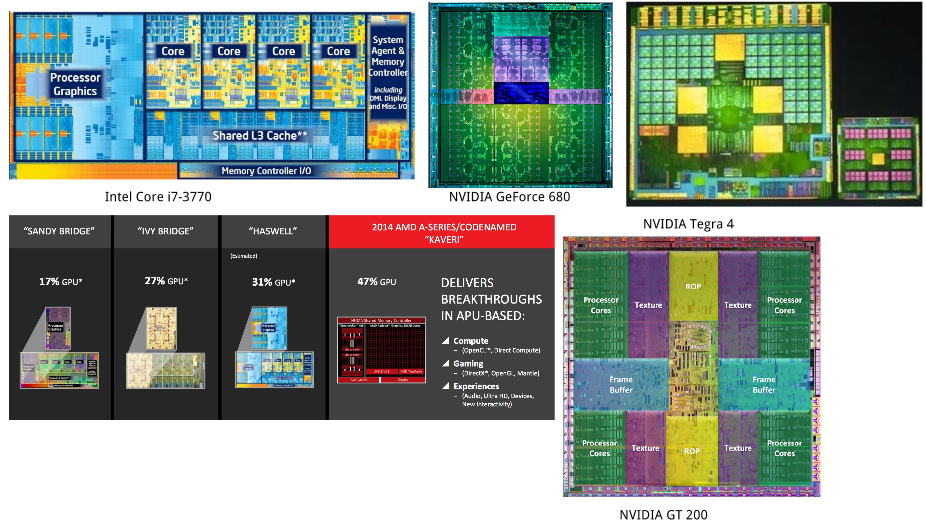

In [3]:
from IPython.display import Image
Image(filename='images/diversity.png', width=600)

## What is OpenCL? 

OpenCL (Open Computing Language) is an
open, royalty-free standard for general purpose
parallel programming across CPUs, GPUs and
other processors.

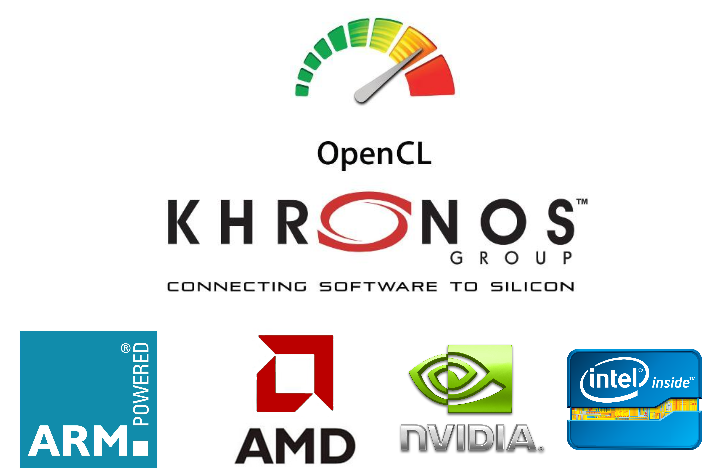

In [4]:
from IPython.display import Image
Image(filename='images/khronos.png', width=500)

Defines:
- Host-side programming interface
    - Abstraction layer for Hardware
    - Query, selection and configuration of OpenCL devices
    - Context creation
    - Creation and management of memory resources
    - Program execution
    
- Device-side programming language
    - OpenCL C: based on C99

### Abstract Architecture (Platform Model)

Specifies the processor coordinating execution (the host) and one or more processors capable of executing OpenCL C code (the devices).


Images from http://mathema.tician.de/software/pyopencl/


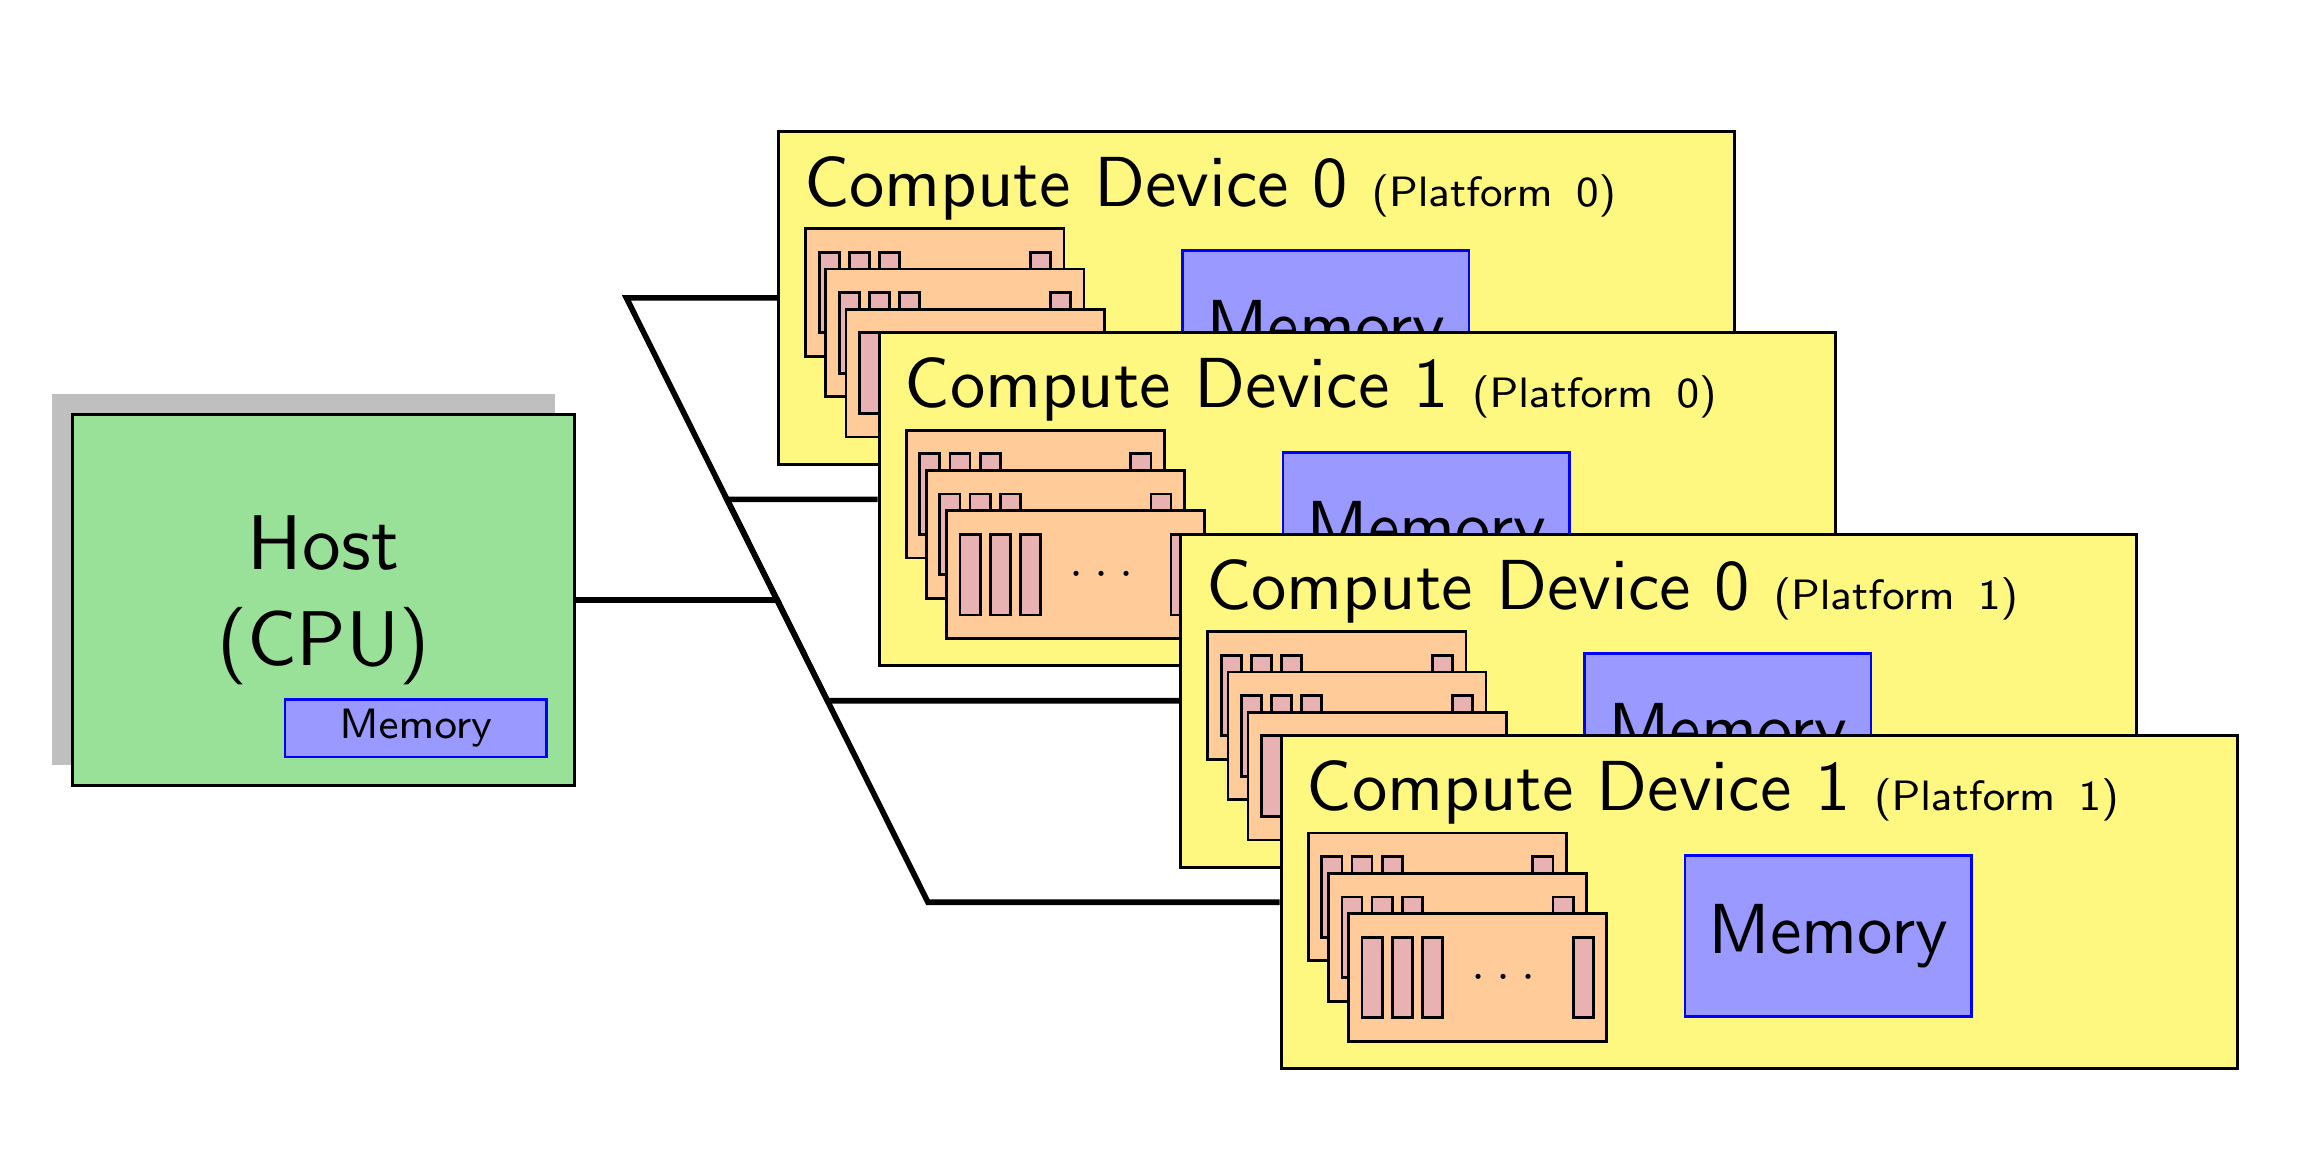

In [5]:
from IPython.display import Image
print "Images from http://mathema.tician.de/software/pyopencl/"
Image(filename='images/schema.png', width=500)


### How to install OpenCL ¿?
- Archlinux: you can find all the packages with yaourt (you have to reboot the system), (opencl-mesa, intel-opencl-runtime intel-opencl-sdk, opencl-nvidia)
- Ubuntu:
    - sudo apt-get install opencl-headers
    - sudo apt-get install beignet beignet-dev beignet-opencl-icd (for intel processors)
    - sudo apt-get install nvidia-opencl-dev
    - [OpenCL for AMD](http://developer.amd.com/tools-and-sdks/opencl-zone/amd-accelerated-parallel-processing-app-sdk/)

### How to install PyOpenCL ¿?

- Via **pip** `$pip install pyopencl`

- Via **anaconda** `$conda install -c derickl pyopencl=2015.1`

### Why PyOpenCL ¿?
- Automatic Cleanup
- Provide complete access
- Automatically manage resources
- Provide abstractions
- Integrate tightly with numpy
- PyOpenCL supports every OS that has an OpenCL implementation.
- Great Documentation! https://documen.tician.de/pyopencl/


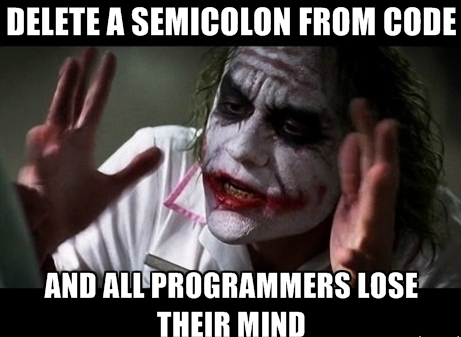

In [6]:
from IPython.display import Image
Image(filename='images/semicolon.jpg', width=400)

##### Compare c++ host code vs python !! (360 lines of c++ code vs 43 lines in python!!

## Starting with PyOpenCL

In [7]:
%load_ext pyopencl.ipython_ext

In [8]:
import pyopencl as cl
import numpy as np
import matplotlib.pyplot as plt

#### What Platform are we using?

In [9]:
platforms = cl.get_platforms()
platforms

[<pyopencl.Platform 'NVIDIA CUDA' at 0x56364e8f3eb0>]

In [10]:
d = platforms[0].get_devices(cl.device_type.ALL)[0]

In [11]:
print "Name:", d.name
print "Version:", d.opencl_c_version
print "Local Memory Size:", d.local_mem_size/1024, "KB"
print "Global Memory Size:", d.global_mem_size/(1024*1024), "MB"
print "Max Alloc Size:", d.max_mem_alloc_size/(1024*1024), "MB"
print "Max Work-group Total Size:", d.max_work_group_size

Name: GeForce GTX 860M
Version: OpenCL C 1.2 
Local Memory Size: 48 KB
Global Memory Size: 2047 MB
Max Alloc Size: 511 MB
Max Work-group Total Size: 1024


### Context and Queue

A context is an abstract container that exists on the host. A context
coordinates the mechanisms for host–device interaction, manages the memory objects that are available to the devices, and keeps track of the programs and kernels
that are created for each device.


#### Several ways to create context

In [12]:
ctx = cl.create_some_context(interactive=True) #Try interactive

Choose platform:
[0] <pyopencl.Platform 'NVIDIA CUDA' at 0x56364e8f3eb0>
Choice [0]:0
Set the environment variable PYOPENCL_CTX='0' to avoid being asked again.


The command queue is the mechanism that the host uses to request action by the device. Once the host decides which devices to work with and a context is created, one command queue needs to be created per device (i.e., each command queue is associated with only one device). Whenever the host needs an action to be performed by a device, it will submit commands to the proper command queue.

imagenes de http://mathema.tician.de/software/pyopencl/


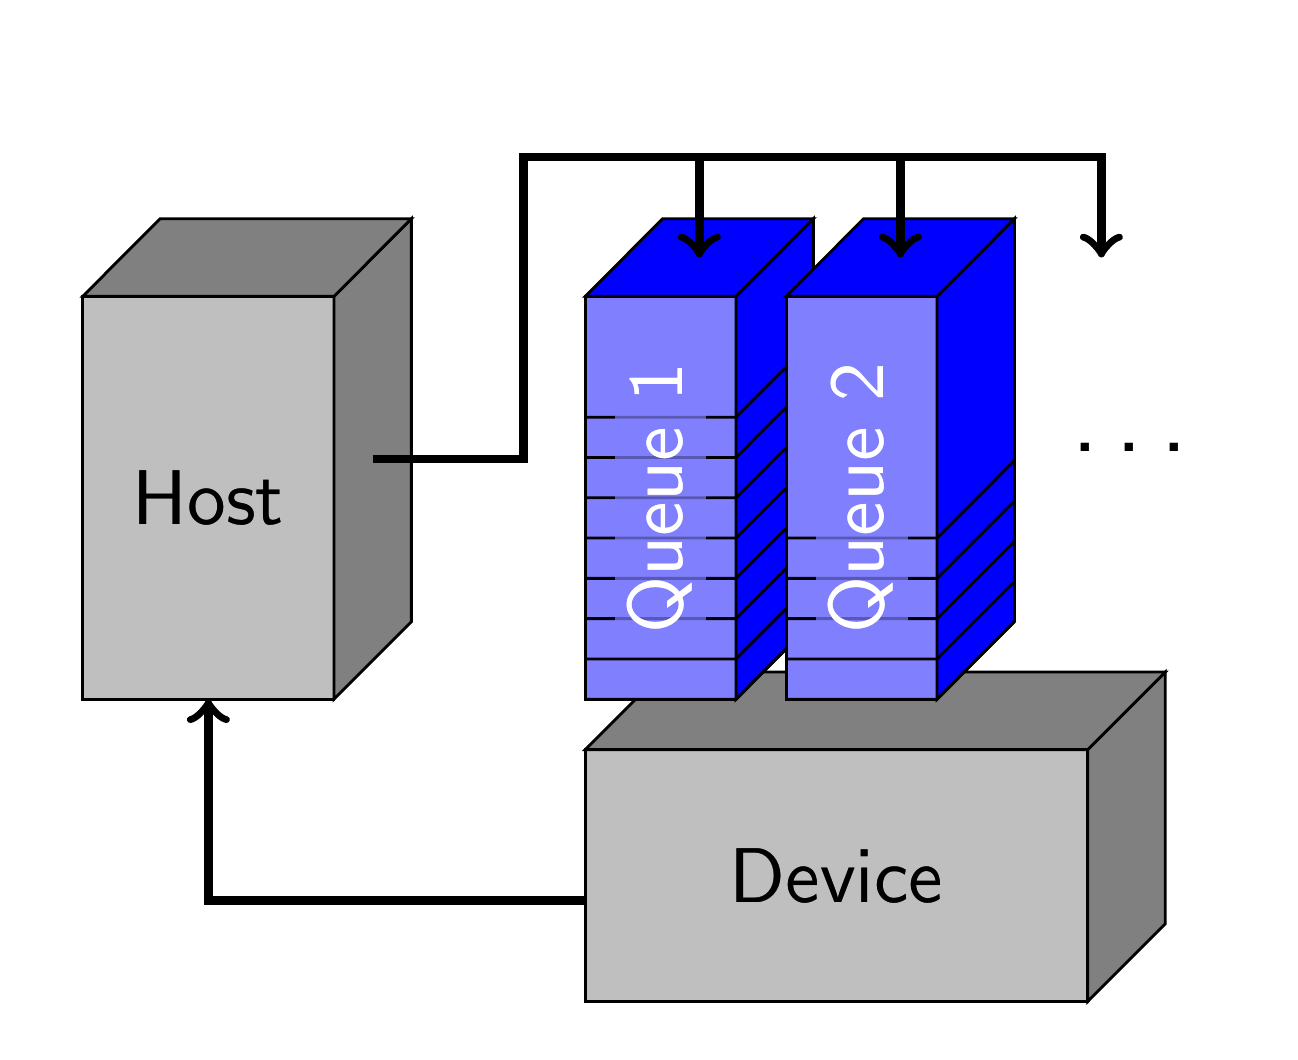

In [12]:
from IPython.display import Image
print "imagenes de http://mathema.tician.de/software/pyopencl/"
Image(filename='images/queue.png', width=300) 

In [13]:
queue = cl.CommandQueue(ctx)

### Events

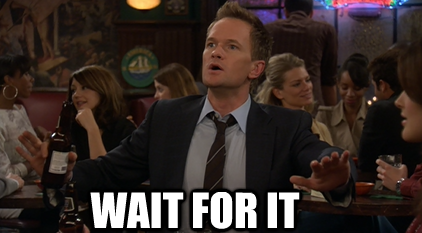

In [14]:
from IPython.display import Image
Image(filename='images/wait.png', width=400) 

Events have two main roles in OpenCL:
- Representing dependencies (`event.wait()`, `enqueue_XXX(queue, ..., wait_for=[evt1, evt2]`)
- Providing a mechanism for profiling


### Memory Objects

In order for data to be transferred to a device, it must first be encapsulated as a memory object.
OpenCL defines two types of memory objects: buffers and images.
Buffers are arrays, where data elements are stored contiguously in memory. Images, on the other hand, are designed as opaque objects, allowing for data padding and other optimizations that may improve performance on devices.


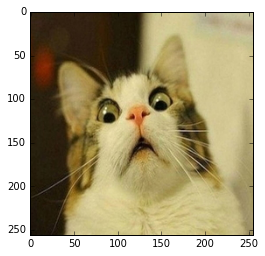

In [14]:
%matplotlib inline
from PIL import Image

im = Image.open('images/other_cat.jpg').convert('RGBA')
im = np.array(list(im.getdata())).astype(np.uint8).reshape((256, 256, 4))
plt.imshow(im)

In [15]:
cl_img_format = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNORM_INT8)

mf = cl.mem_flags
img_input  = cl.Image(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, cl_img_format, (im.shape[0], im.shape[1]), hostbuf=im)

In [16]:
img_input.release()

In [17]:
mf = cl.mem_flags

my_matrix = np.random.rand(1024000).astype(np.float32)
my_matrix_result = np.empty_like(my_matrix)

my_matrix_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=my_matrix)
my_result_buf = cl.Buffer(ctx, mf.WRITE_ONLY, my_matrix_result.nbytes)


In [18]:
print type(my_matrix_buf)
print my_matrix, my_matrix.shape

<class 'pyopencl.cffi_cl.Buffer'>
[ 0.88066298  0.62650663  0.14271447 ...,  0.92727304  0.30830133
  0.48210934] (1024000,)


### Program Objects

A program is a collection of functions called kernels, where kernels are units of execution that can be scheduled to run on a device.

In [19]:
c_code = """
        __kernel void dob(__global const float *a,
        __global float *c)
        {
          int gid = get_global_id(0);
          c[gid] = a[gid] + a[gid];
        }
        """

In [20]:
my_matrix_result

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [21]:
program = cl.Program(ctx, c_code).build()

In [22]:
run = program.dob(queue, my_matrix_result.shape, None, my_matrix_buf, my_result_buf)

In [23]:
cl.enqueue_copy(queue, my_matrix_result, my_result_buf)

In [24]:
assert((my_matrix + my_matrix)  == my_matrix_result).all()

In [25]:
my_result_buf.release(), my_matrix_buf.release()

(None, None)

### Image Operations

#### Rotation

images from Heterogeneous Computing with OpenCL


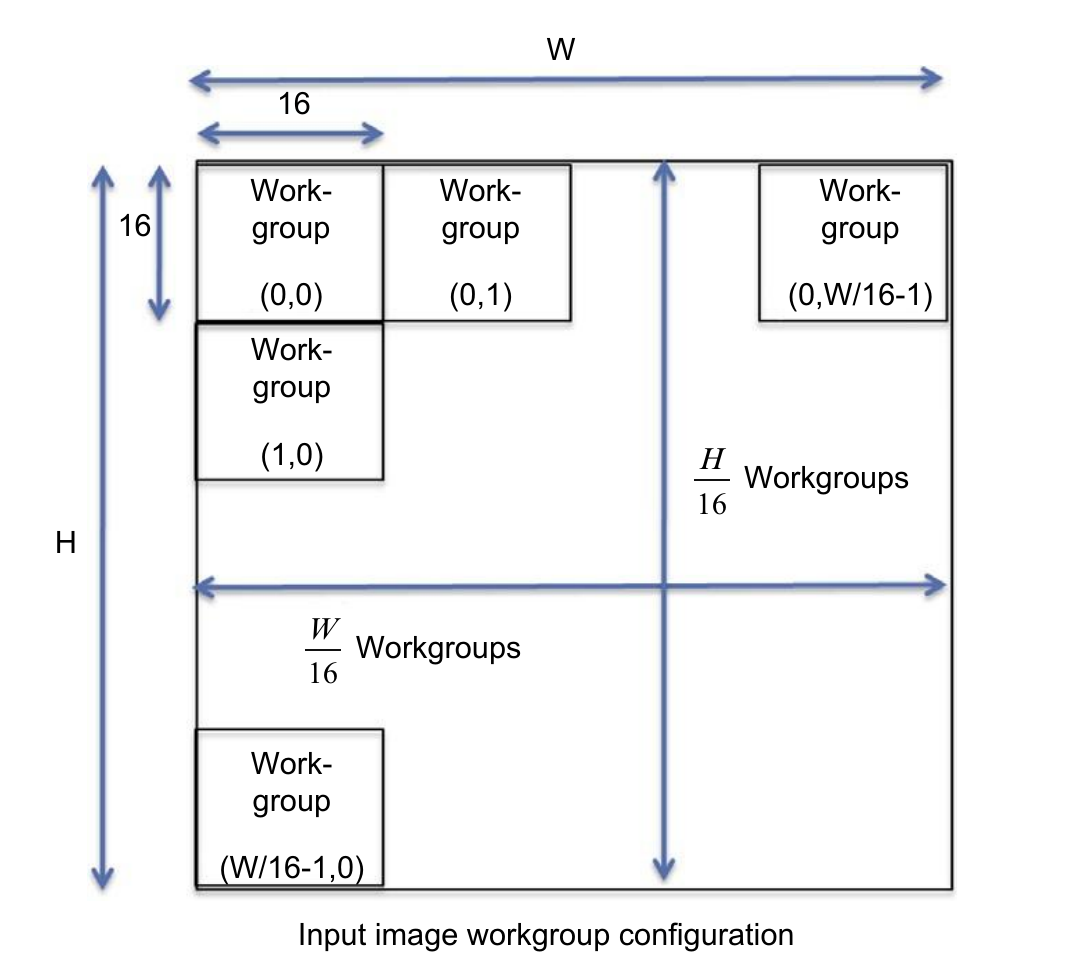

In [27]:
from IPython.display import Image
print "images from Heterogeneous Computing with OpenCL"
Image(filename='images/image_setup.png', width=400) 

In [26]:
import pyopencl.array as array

##### Create a queue and context ..

In [27]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

##### Load Image as numpy array

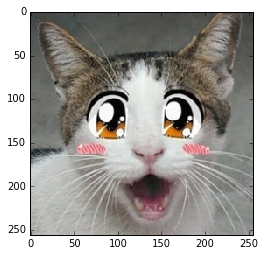

In [28]:
%matplotlib inline
from PIL import Image

im = Image.open('images/cat.jpg').convert('RGBA')
im = np.array(list(im.getdata())).astype(np.uint8).reshape((256, 256, 4))
plt.imshow(im, interpolation='nearest')

##### Create buffers for the image input and output

In [29]:
my_im = array.to_device(queue, im)
my_out = array.zeros_like(my_im)

In [31]:
my_im.data, my_im

(<pyopencl.cffi_cl.Buffer at 0x7f74dc7b65d0>, array([[[ 70,  74,  73, 255],
         [ 64,  68,  67, 255],
         [ 65,  69,  68, 255],
         ..., 
         [ 68,  69,  64, 255],
         [ 66,  67,  62, 255],
         [ 69,  68,  64, 255]],
 
        [[ 66,  70,  69, 255],
         [ 68,  70,  69, 255],
         [ 67,  71,  70, 255],
         ..., 
         [ 67,  67,  65, 255],
         [ 69,  70,  65, 255],
         [ 70,  71,  66, 255]],
 
        [[ 67,  68,  70, 255],
         [ 65,  69,  70, 255],
         [ 67,  71,  72, 255],
         ..., 
         [ 67,  67,  65, 255],
         [ 66,  67,  62, 255],
         [ 65,  66,  61, 255]],
 
        ..., 
        [[172, 172, 170, 255],
         [174, 174, 172, 255],
         [168, 168, 166, 255],
         ..., 
         [148, 150, 145, 255],
         [151, 153, 148, 255],
         [152, 154, 149, 255]],
 
        [[172, 174, 171, 255],
         [174, 174, 172, 255],
         [170, 170, 168, 255],
         ..., 
         [151, 15

##### Write the kernel following the rotation matrix

In [32]:
%%cl_kernel -o "-cl-fast-relaxed-math"

__kernel void img_rotate(__global float* dest_data, 
                         __global float* src_data,    
                         int  w_image,    
                         int  h_image, 
                         float  sin_theta, 
                         float  cos_theta) { 

   int2 coord = (int2) (get_global_id(0), get_global_id(1));

   float x0 = w_image/2.0f;
   float y0 = h_image/2.0f;

   float2 offset = (float2) (coord.x - x0, coord.y - y0);

   int xpos = (int)(offset.x*cos_theta + offset.y*sin_theta + x0 );
   int ypos = (int)(offset.y*cos_theta - offset.x*sin_theta + y0 ); 

   // Bounds Checking 
   if((xpos>=0) && (xpos< w_image) && (ypos>=0) && (ypos< h_image)) {
      dest_data[coord.y*w_image+coord.x] = src_data[ypos*w_image+xpos];    
   }
}

##### Give the angle for the rotation ..

In [33]:
cos_theta = np.float32(np.cos(65))
sin_theta = np.float32(np.sin(65))

##### And run it!

In [34]:
img_rotate(queue, my_im.shape, None, my_out.data, my_im.data,
           np.int32(256), np.int32(256), sin_theta, cos_theta)

##### And you can retrive your data with the get method!!! ( pretty great right?!)

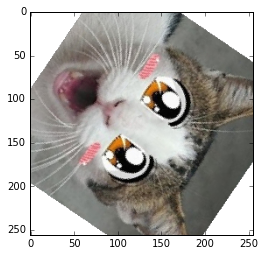

In [35]:
plt.imshow(my_out.get())

### Now let's try some blur ..

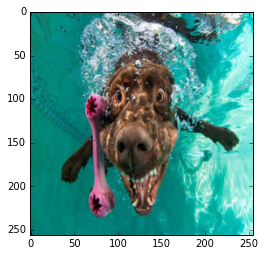

In [36]:
%matplotlib inline
from PIL import Image

im = Image.open('images/dog.png').convert('RGBA')
im = np.array(list(im.getdata())).astype(np.uint8).reshape((256, 256, 4))
plt.imshow(im)

In OpenCL, samplers are objects that describe how to access an image. Samplers specify the type of coordinate system, what to do when out-of-bounds accesses occur, and whether or not to interpolate if an access lies between multiple indices.

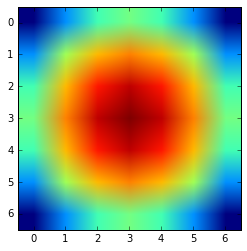

In [37]:
kernel_size = 7
sigma = 10.

def calc_gaussian_kernel(kernel_size=11, sigma=10.):
    kernel = np.zeros((kernel_size, kernel_size), np.float32)
    for x in range(kernel_size):
        for y in range(kernel_size):
            dx, dy = (x - kernel_size / 2), (y - kernel_size / 2)
            kernel[x, y] = np.exp(-dx**2/(2*sigma**2)-dy**2/(2*sigma**2))
    kernel /= np.sum(kernel)
    return kernel

gaussian_kernel = calc_gaussian_kernel(kernel_size, sigma)
plt.imshow(gaussian_kernel)
#gaussian_kernel

#### Create Queue and Context

In [38]:
w, h = im.shape[:2][::-1]

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

### Write the kernel... with image objects

In [39]:
%%cl_kernel -o "-cl-fast-relaxed-math"
__kernel void gauss(__read_only image2d_t img,
                    __write_only image2d_t res,
                    __constant float * gaussian_kernel
                    ) {
    const int  HALF_FILTER_SIZE = 3.;
    const sampler_t smp = CLK_NORMALIZED_COORDS_FALSE | CLK_FILTER_NEAREST | CLK_ADDRESS_CLAMP_TO_EDGE;
    int2 coord = (int2) (get_global_id(0), get_global_id(1));
    int2 img_size = (int2) (get_image_width(img), get_image_height(img));
    if (any(coord >= img_size)) {
        return;
    }
    
    float4 color = (float4) 0.0;
    int kernel_index = 0;
    for (int dx = -HALF_FILTER_SIZE; dx <= HALF_FILTER_SIZE; ++dx) {
        for (int dy = -HALF_FILTER_SIZE; dy <= HALF_FILTER_SIZE; ++dy, ++kernel_index) {
            color += read_imagef(img, smp, coord + (int2) (dx, dy)) * gaussian_kernel[kernel_index];
        }
    }
    write_imagef(res, coord, color);
}

#### Create buffers for I/O

In [40]:
cl_img_format = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNORM_INT8)

mf = cl.mem_flags
img_input  = cl.Image(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, cl_img_format, (w, h), hostbuf=im)
img_output = cl.Image(ctx, mf.WRITE_ONLY, cl_img_format, (w, h))
buf_kernel = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=gaussian_kernel)

#### Run the program

In [42]:
gauss(queue, (w, h), (16, 16), img_input, img_output, buf_kernel).wait()

#### Read the results from the queue

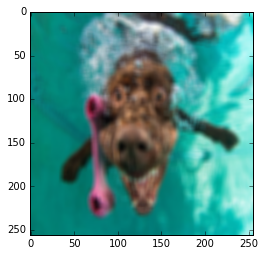

In [43]:
import matplotlib.pyplot as plt
result_img = np.zeros((h, w, 4), np.uint8)
cl.enqueue_copy(queue, result_img, img_output, origin=(0, 0, 0), region=(w, h, 1)).wait()
plt.imshow(result_img)

## Want to learn more?
[Andreas Klöckner's web page](https://mathema.tician.de/software/pyopencl/)

images from Heterogeneous Computing with OpenCL


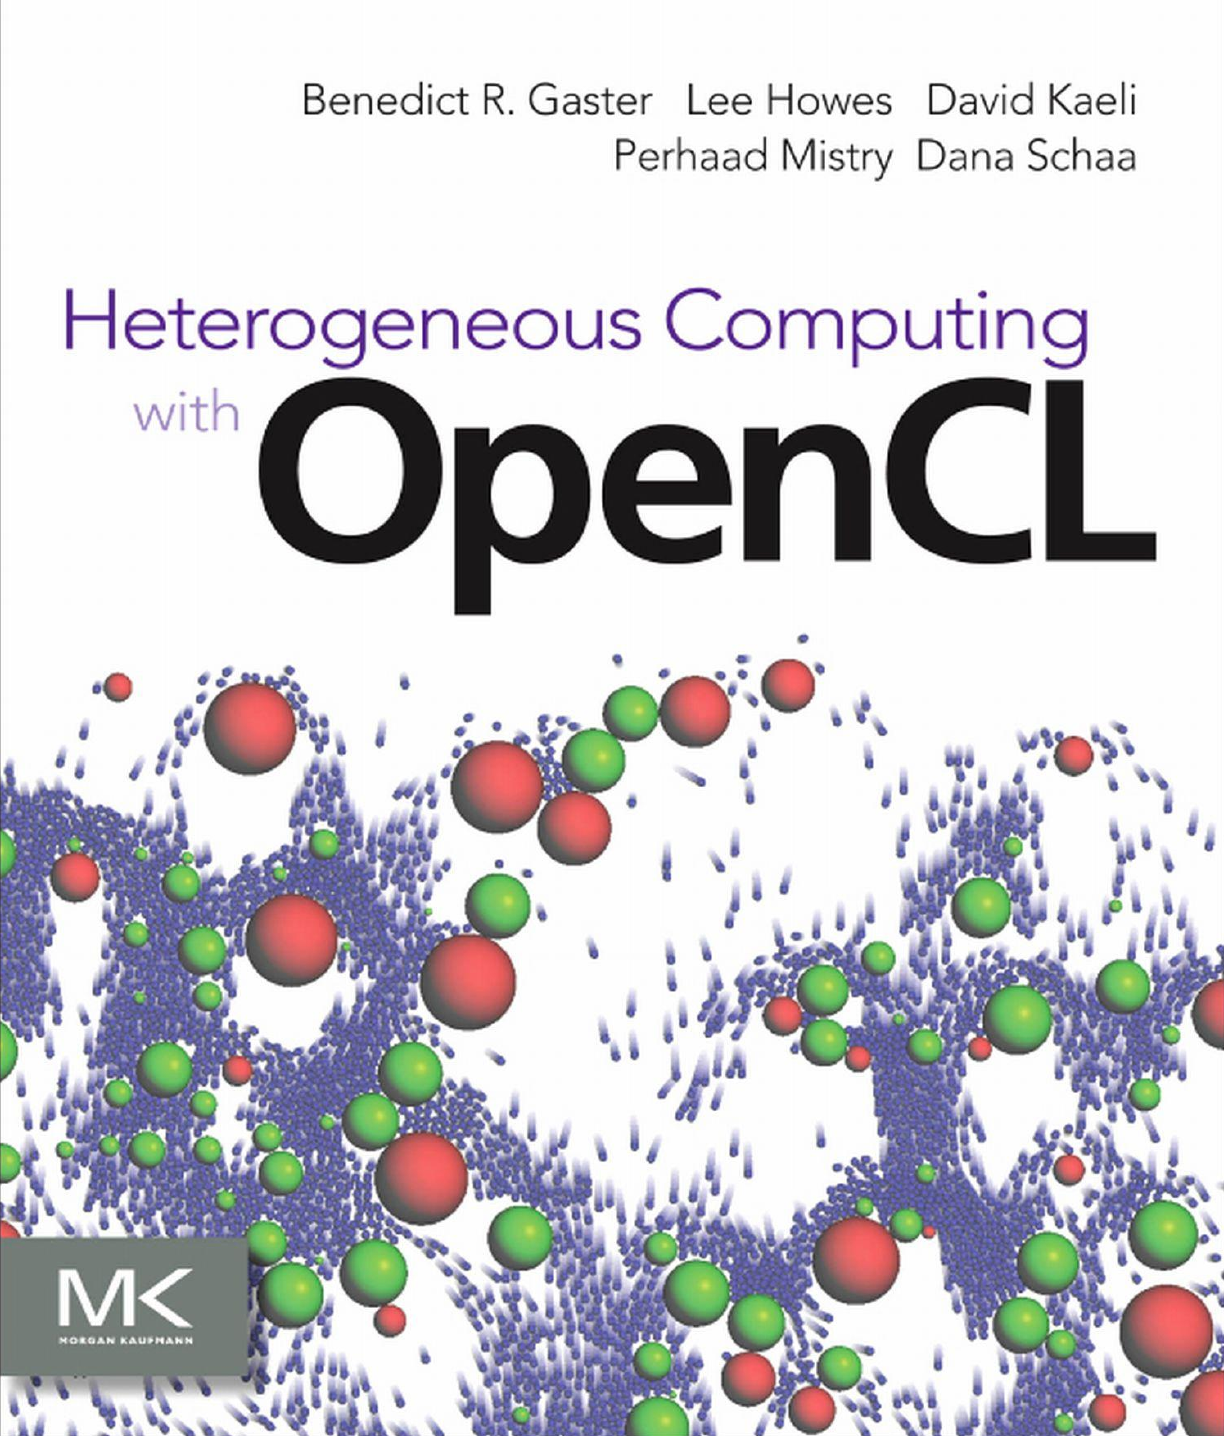

In [44]:
from IPython.display import Image
print "images from Heterogeneous Computing with OpenCL"
Image(filename='images/cover.png', width=400) 